# Tester notebook for RCC

In [1]:
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import mapping
from tqdm import tqdm
import pandas as pd
import matplotlib.colors as mcolors
import random
#from clustering import *
from radially_constrained_cluster import *



In [2]:
italy_region = gpd.read_file('/work/users/jgrassi/data/italy.shp')

def plot_map(geo_df, column_to_color, cmap, vmin, vmax, title):

    # Defining the figure
    fig, ax = plt.subplots(1,1, figsize=(6,6)) 

    
    # Plot the map
    cax = geo_df.plot(column=column_to_color, cmap=cmap, ax=ax, legend=False, vmin=vmin, vmax=vmax)

    # Adding regional boundaries
    italy_region.boundary.plot(color = 'k', linewidth = 0.5, label = 'Regioni', ax=ax)

    # Customize the axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Longitude [°E]')
    ax.set_ylabel('Latitude [°N]')
    ax.grid(alpha=0.3)

    # Creating a custom colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax)

    ax.set_title(title)

    return ax, fig, cbar

In [48]:
#    abruzzo 1
#     puglia 2
#     basilicata 3
#     calabria 4
#     campania 5
#     emiliaromagna 6
#     friulivg 7
#     lazio = 8
#     liguria 9 
#     lombardia 10
#     marche 11
#     molise 12
#     piemonte 13
#     sardegna 14
#     sicilia 15
#     toscana 16
#     trentinoag 17
#     umbria 18
#     aosta 19
#     veneto 20

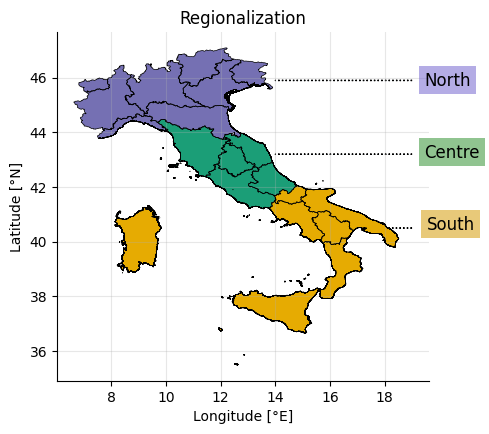

In [3]:
north  = [5,6,8,9,12,16,18,19]
center = [0,7,10,15,17]
south = [1,2,3,4,11,13,14]

north_shp = italy_region.loc[north]
center_shp = italy_region.loc[center]
south_shp = italy_region.loc[south]

tot = []

for g, b in zip([north_shp, center_shp, south_shp],['North','Centre','South']):

    new = gpd.GeoDataFrame(g)
    new.columns = ['geometry']
    new['macro_region'] = b
    gdf = new.set_geometry('geometry')
    tot.append(gdf)


tot = pd.concat(tot)

fig, ax, cbar = plot_map(tot, 'macro_region', 'Dark2', 0, 3, 'Regionalization')
cbar.remove()

ax.text(0.815, 0.72, "North", size=12,ha="right", va="top",bbox=dict(boxstyle="square",facecolor='slateblue', alpha=0.5, edgecolor='none'))
ax.text(0.83, 0.60, "Centre", size=12,ha="right", va="top",bbox=dict(boxstyle="square",facecolor='forestgreen', alpha = 0.5, edgecolor='none'))
ax.text(0.821, 0.48, "South", size=12,ha="right", va="top",bbox=dict(boxstyle="square",facecolor='goldenrod', alpha = 0.6, edgecolor='none'))

plt.arrow(14, 45.9, 5, 0,  linestyle='dotted')
plt.arrow(14, 43.2, 5, 0,  linestyle='dotted')
plt.arrow(18.1, 40.5, 0.9, 0,  linestyle='dotted')

In [50]:
data_path = '/work/users/jgrassi/data/ERA5'

data_obj = []

for files in ['2m_temperature/temperature_19*.nc', 'total_precipitation/precipitation_19*.nc']:

    obj = xr.open_mfdataset(rf'{data_path}/{files}')
    obj = obj.convert_calendar('noleap').rolling(time=10*24, center=True).mean().load()

    obj.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
    obj.rio.write_crs("epsg:4326", inplace=True)

    data_obj.append(obj)

0it [00:00, ?it/s]

(365, 3024)


100%|██████████| 2000/2000 [00:32<00:00, 60.61it/s]
1it [00:49, 49.03s/it]

(365, 1694)


100%|██████████| 2000/2000 [00:18<00:00, 106.20it/s]
2it [01:23, 40.47s/it]

(365, 2674)


100%|██████████| 2000/2000 [00:29<00:00, 67.56it/s]
3it [02:09, 43.27s/it]


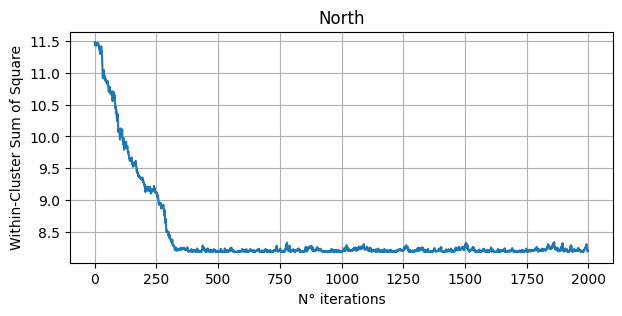

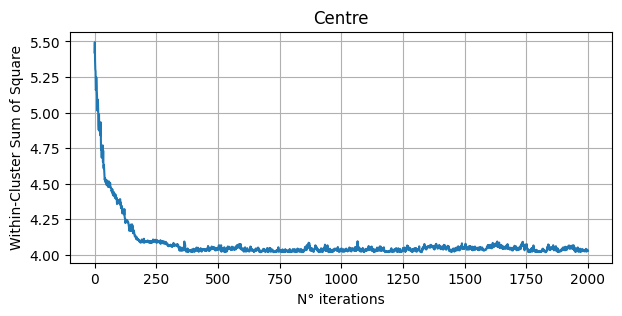

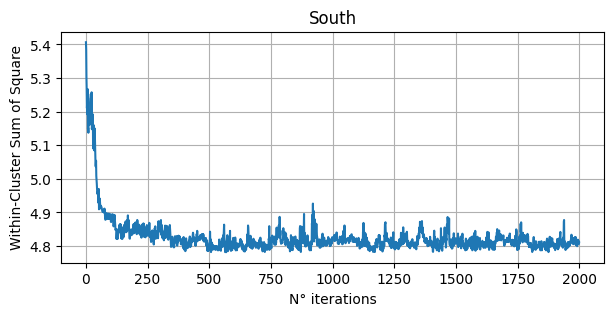

In [59]:
italy_region = gpd.read_file('/work/users/jgrassi/data/italy.shp')


periods = [['1979','1982'],['1982','1985'],['1985','1988'],['1988','1991'],['1991','1994'],['1994','1997'],['1997','2000']]

bp_macro = []
tot = []

for j, name in tqdm(zip([north, center, south],['North','Centre','South'])):

    gpp = italy_region.loc[j]
    new = gpd.GeoDataFrame(gpp)
    new.columns = ['geometry']
    gdf = new.set_geometry('geometry')


    arrays = []

    for obj, var in zip(data_obj, ['t2m','tp','sfcWind']):

        for j in periods:

            obj_rast = obj.sel(time=slice(j[0], j[1]))
            obj_rast = obj_rast.groupby('time.dayofyear').mean()
            obj_rast = obj_rast.rio.clip(gdf.geometry.apply(mapping), gdf.crs, drop=True)

            obj_array = obj_rast[var].to_numpy()
            obj_array = np.reshape(obj_array, (365, obj_array.shape[1]*obj_array.shape[2]))
            arrays.append(obj_array)



    # concatenate the two arrays on columns
    array_tot = np.concatenate((arrays), axis=1)
    array_tot = array_tot[:,~np.all(np.isnan(array_tot), axis=0)]
    print(array_tot.shape)

    # min-max normalization on axis 1
    array_tot = (array_tot - array_tot.min(axis=1).reshape(-1, 1)) / (array_tot.max(axis=1) - array_tot.min(axis=1)).reshape(-1, 1)


    model = Radially_Constrained_Cluster(data_to_cluster = array_tot,
                                     n_seas = 4,
                                     n_iter = 2000,
                                     learning_rate = 1,
                                     min_len=30,
                                     mode = 'single')

    model.fit()

    fig_learning = plt.figure(figsize = (7,3))
    plt.plot(model.error_history)
    plt.grid()
    plt.title(name)
    plt.xlabel('N° iterations')
    plt.ylabel('Within-Cluster Sum of Square')

    gdf['macro_region'] = name
    gdf['spring_onset'] = model.breakpoints[0]
    gdf['summer_onset'] = model.breakpoints[1]
    gdf['autumn_onset'] = model.breakpoints[2]
    gdf['winter_onset'] = model.breakpoints[3]

    gdf['spring_lenght'] = model.breakpoints[1] -model.breakpoints[0]
    gdf['summer_lenght'] = model.breakpoints[2] -model.breakpoints[1]
    gdf['autumn_lenght'] = model.breakpoints[3] -model.breakpoints[2]
    gdf['winter_lenght'] = 365 - model.breakpoints[3] + model.breakpoints[0]

    tot.append(gdf)

tot = pd.concat(tot)

In [60]:
tot.drop(columns='geometry').groupby('macro_region').mean()

,spring_onset,summer_onset,autumn_onset,winter_onset,spring_lenght,summer_lenght,autumn_lenght,winter_lenght
macro_region,,,,,,,,
Centre,62.0,186.0,303.0,363.0,124.0,117.0,60.0,64.0
North,56.0,169.0,309.0,360.0,113.0,140.0,51.0,61.0
South,63.0,185.0,289.0,364.0,122.0,104.0,75.0,64.0


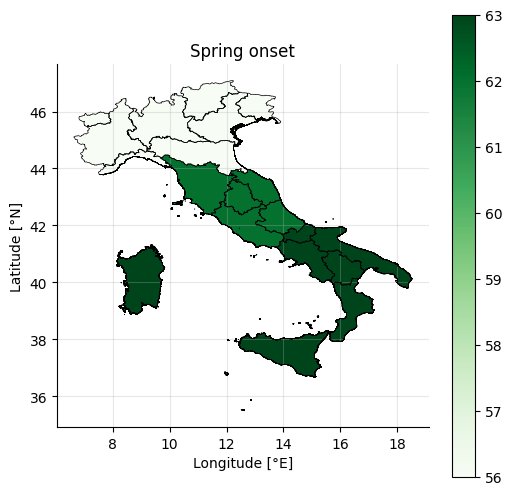

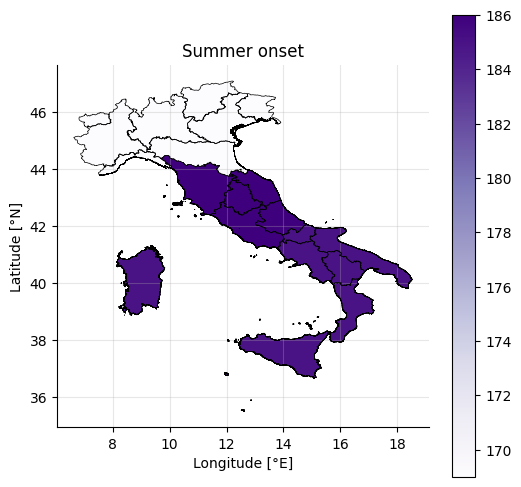

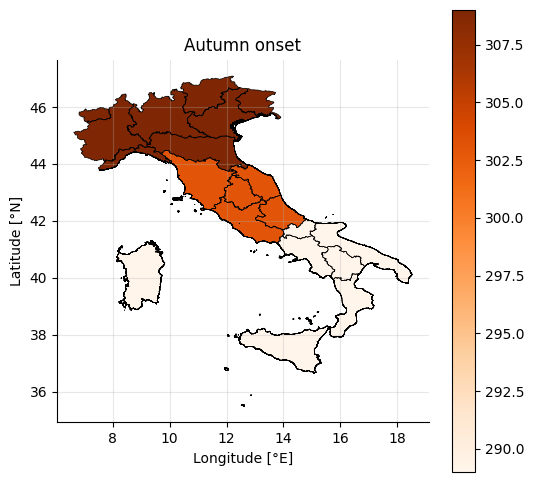

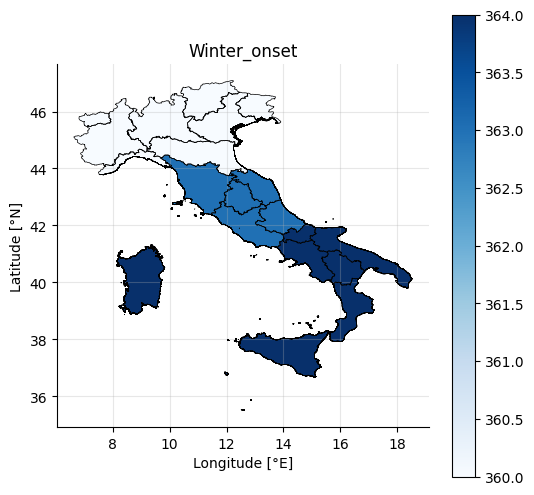

In [61]:
for onset, title, cmap in zip(['spring_onset','summer_onset','autumn_onset','winter_onset'],
                            ['Spring onset','Summer onset','Autumn onset','Winter_onset'],
                            ['Greens', 'Purples','Oranges','Blues']):
    
    fig, ax, cbar = plot_map(tot, onset, cmap, tot[onset].min(), tot[onset].max(), title)


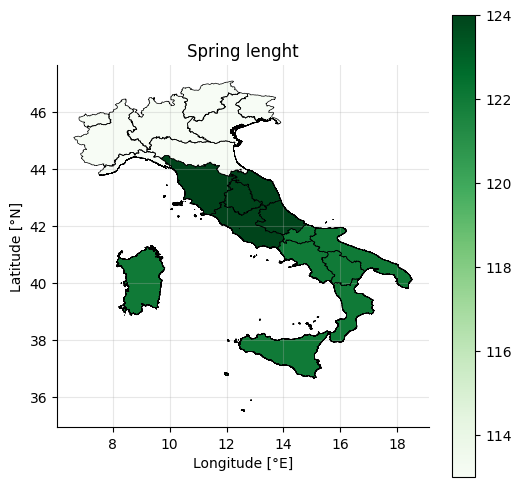

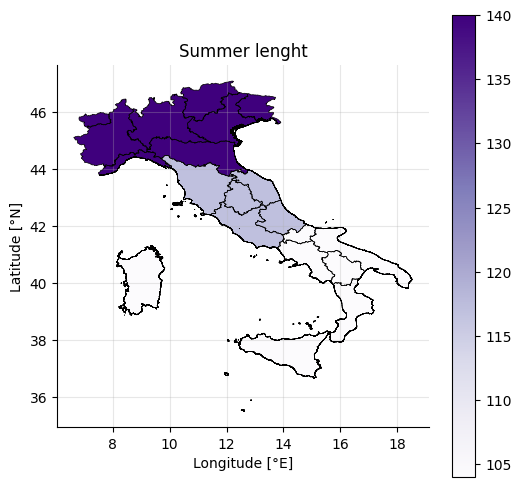

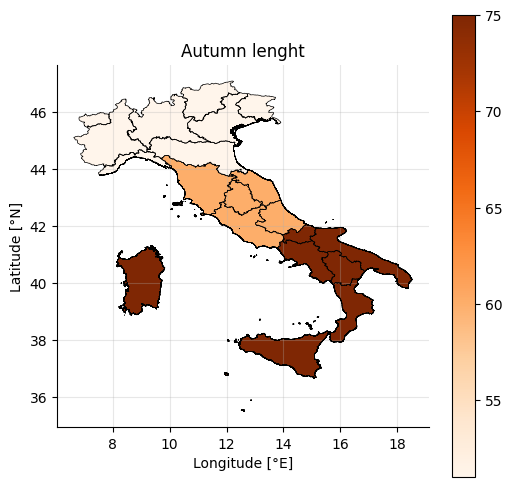

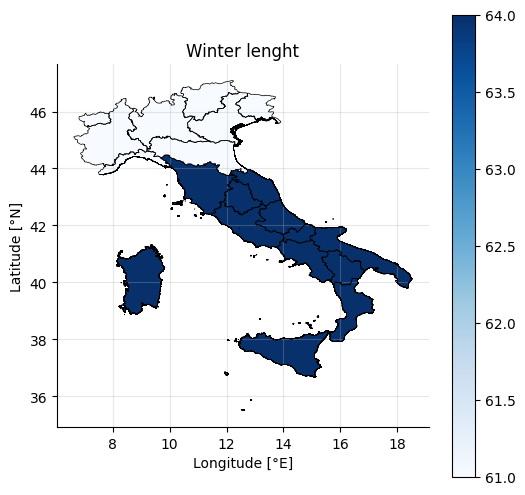

In [62]:
for lenght, title, cmap in zip(['spring_lenght','summer_lenght','autumn_lenght','winter_lenght'],
                            ['Spring lenght','Summer lenght','Autumn lenght','Winter lenght'],
                            ['Greens', 'Purples','Oranges','Blues']):
    
    fig, ax, cbar = plot_map(tot, lenght, cmap, tot[lenght].min(), tot[lenght].max(), title)
